# Training Data Preparation for Random Forest

In [2]:
# will add these to our environment, srry!
# 
pip install xgboost
!pip install cmocean
!pip install glidertools
!pip install pygam
!pip install hyperopt
!pip install dataframe_image
!pip install gsw
!pip install PyCO2SYS

  Using cached xgboost-1.7.1-py3-none-manylinux2014_x86_64.whl (193.6 MB)
  Using cached cmocean-2.0-py3-none-any.whl (223 kB)
  Using cached glidertools-2021.3-py3-none-any.whl (82 kB)
  Using cached numexpr-2.8.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (381 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached skyfield-1.45-py3-none-any.whl (442 kB)
  Using cached seawater-3.3.4-py3-none-any.whl
  Using cached jplephem-2.18-py3-none-any.whl (46 kB)
  Using cached sgp4-2.21-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (229 kB)
  Using cached pygam-0.8.0-py2.py3-none-any.whl (1.8 MB)
  Using cached future-0.18.2-py3-none-any.whl
  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
  Using cached python_utils-3.4.5-py2.py3-none-any.whl (23 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached cloudpickle-2.2.0-py3-none-any.whl (25 kB)
  Using cached py4j-0.10.9.7-p

In [46]:
# Import Packages

#Data Structure/Organization Packages
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning/Statistics Packages
from scipy.stats import kde
from scipy.stats import iqr
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics
import xgboost as xgb
from pygam import LinearGAM, l, s, f
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error

# Utility Packages
import random as rand
import os
import math
import dataframe_image as dfi
import itertools
from scipy import interpolate

# Oceanography Packages
import gsw
import PyCO2SYS as pyco2

import sogos_module as sg

In [2]:
# Set up directories
# float_directory = "../data/float/"
# ship_filepath = "../data/bottle_data.csv"

# Song local
float_directory = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS/data/float/'
ship_filepath = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS/data/ship/bottle_data.csv'

In [7]:
# temp check for song
# ds = xr.open_dataset('/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS/325020190403_bottle.nc')
# ds.bottle_salinity

## Ship Data

- Bottle Data from GO-SHIP I06 Cruise (2019)
- [Ship Data Link](https://uwnetid-my.sharepoint.com/:f:/g/personal/sangsong_uw_edu/ErLtPwS6pdZClgo0Flp9lq8BoNBWNN6mE2LJuJJVmt874A?e=qHB9qp)

In [3]:
# Load Ship Data (Already QC Filtered) into Pandas Dataframe
ship_DF = pd.read_csv(ship_filepath)

ship_DF["Julian Day"] = pd.to_datetime(ship_DF["Julian Day"].values/1440, unit='D', origin=pd.Timestamp('1980-01-01'))
ship_DF['Yearday'] = sg.datetime2ytd(ship_DF['Julian Day'])


In [20]:
# Add CT and SA to ship_DF
ship_DF["SA"] = gsw.SA_from_SP(ship_DF["Salinity"], ship_DF["Pressure"], ship_DF["Longitude"], ship_DF["Latitude"])
ship_DF["CT"] = gsw.CT_from_t(ship_DF["SA"], ship_DF["Temperature"], ship_DF["Pressure"])
# See note for pH correction below
ship_DF = ship_DF.rename(columns={'pH':'pH_lab'})

In [21]:
ship_DF.head()

,Latitude,Longitude,Julian Day,Bottle Depth,Pressure,Temperature,Salinity,Oxygen,Nitrate,DIC,Alkalinity,pH_lab,Yearday,SA,CT
0,-68.3422,31.535,2019-04-16 09:07:00,524,522.0,0.7214,34.6535,210.8,32.03,2252.1,2348.73,7.5811,105.379861,34.824140,0.698461
1,-68.3422,31.535,2019-04-16 09:07:00,524,505.4,0.7200,34.6525,211.0,32.02,NaN,NaN,NaN,105.379861,34.823094,0.697907
2,-68.3422,31.535,2019-04-16 09:07:00,524,490.7,0.7193,34.6523,211.0,31.94,2250.7,2346.14,7.5831,105.379861,34.822833,0.697944
3,-68.3422,31.535,2019-04-16 09:07:00,524,439.7,0.7221,34.6491,211.1,32.01,NaN,NaN,NaN,105.379861,34.819407,0.703262
4,-68.3422,31.535,2019-04-16 09:07:00,524,388.8,0.4779,34.5828,221.2,32.09,2250.4,2339.87,7.5826,105.379861,34.752592,0.462921


***pH correction***
- Note: one pH correction must be performed for the ship bottle data
- Bottle data is analyzed in lab conditions (25 degC, 0 atm)
- Rest of ship measurements are in-situ, so we transform the variables to the appropriate environmental temp/pressure using the PyCO2Sys package

In [25]:
## Bottle pH Corrections --  ~1min runtime
pH_situ = []
for i in range(len(ship_DF)):
    # lab conditions
    pressure = 0            
    temperature = 25

    # convert to ship in-situ conditions
    try:
        result = pyco2.sys(par1 = ship_DF["Alkalinity"][i],
                           par1_type = 1,
                           par2 = ship_DF["pH_lab"][i],
                           par2_type = 3,
                           opt_pH_scale = 1,
                           salinity = ship_DF["SA"][i],
                           temperature = temperature,
                           temperature_out = ship_DF["CT"][i],
                           pressure = pressure,
                           pressure_out = ship_DF["Pressure"][i]
                          )
        pH_out = result["pH_out"]
    except SyntaxError: pH_out = np.nan
    pH_situ.append(pH_out)
pH_situ
ship_DF['pH']= pH_situ

KeyError: 'pH_lab'

In [28]:
ship_DF.head()

,Yearday,Julian Day,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH
0,105.379861,2019-04-16 09:07:00,-68.3422,31.535,522.0,34.824140,0.698461,210.8,32.03,7.938548
1,105.379861,2019-04-16 09:07:00,-68.3422,31.535,505.4,34.823094,0.697907,211.0,32.02,NaN
2,105.379861,2019-04-16 09:07:00,-68.3422,31.535,490.7,34.822833,0.697944,211.0,31.94,7.942037
3,105.379861,2019-04-16 09:07:00,-68.3422,31.535,439.7,34.819407,0.703262,211.1,32.01,NaN
4,105.379861,2019-04-16 09:07:00,-68.3422,31.535,388.8,34.752592,0.462921,221.2,32.09,7.949975


## Float Data and Corrections

- Use all QC-ed data from the 7 Argo floats that were deployed during the GO-SHIP cruise from which the shipboard data abve comes
- [Float Data Link](https://uwnetid-my.sharepoint.com/:f:/g/personal/sangsong_uw_edu/Es-ESkVfIlpHhpFq7o5LTaoBk6IOFXMqQ8wFCgLMA512uw?e=7cWT6J)


In [8]:
floatDSdict = {}
for filename in os.listdir(float_directory):
    fp = float_directory + filename
    DS = xr.open_dataset(fp, decode_times=False)
    floatDSdict[filename[0:7]] = DS                 # pulls float ID from the filename string 

## Check float quality control
flag = 0
for floatnum in floatDSdict:
    for prof in floatDSdict[floatnum]["PARAMETER_DATA_MODE"]:
        data_modes = np.concatenate((prof.values[-2:],prof.values[0:4]))
        if np.all((data_modes == b'D') | (data_modes == b'A')) == False:
            flag = 1
if flag == 0:
    print("Data Mode is all D or A! All Good!")

Data Mode is all D or A! All Good!


In [11]:
# Create a pandas DataFrame for all float data (long - collapse!)
# From BGC-Argo Toolbox
def make_float_DF(floatDSdict):
    """
    Create a dictionary with all necesary data fields from Argo.

    # We Want the following data: 
    # Data Type, Date Update, LATITUDE, LONGITUDE, Position QC, PRES_ADJUSTED, PRES_ADJUSTED_QC,
    # TEMP_ADJUSTED, TEMP_ADJUSTED_QC, PSAL_ADJUSTED, PSAL_ADJUSTED_QC, DOXY_ADJUSTED, DOXY_ADJUSTED_QC
    # CHLA_ADJUSTED, CHLA_ADJUSTED_QC, NITRATE_ADJUSTED, NITRATE_ADJUSTED_QC

    # Data Type is structured differently so we will process the QC in a different way.
    """
    
    TrainingData = {
        # "Serial Number" : [],
        # "Data Mode": [],
        "Julian Day" : [],
        "Julian Day QC" : [],
        "Latitude" : [],
        "Longitude" : [],
        "Position QC" : [],
        "Pressure" : [],
        "Pressure QC": [],
        "Temperature Adjusted" : [],
        "Temperature Adjusted QC" : [],
        "Temperature" : [],
        "Temperature QC" : [],
        "Salinity Adjusted" : [],
        "Salinity Adjusted QC" : [],
        "Salinity" : [],
        "Salinity QC" : [],
        "Oxygen" : [],
        "Oxygen QC" : [],
        "Nitrate": [],
        "Nitrate QC": [],
        "pH": [],
        "pH QC": []
    }

    # Iterate through all floats in float dictionary
    for floatnum in floatDSdict:
        # Establish empty lists to append data to
        # float_serial = []
        # data_mode = []
        float_juld = []
        juld_QC = []
        float_lat = []
        float_lon = []
        position_QC = []
        float_pres = []
        pres_QC = []
        float_temp_adj = []
        temp_adj_QC = []
        float_temp = []
        temp_QC = []
        float_sal = []
        sal_QC = []
        float_sal_adj = []
        sal_adj_QC = []
        float_ox = []
        ox_QC = []
        nit = []
        nit_QC = []
        pH = []
        pH_QC = []
        # Iterate through every profile of a specific float
        for iprof in floatDSdict[floatnum].N_PROF.values:
            # Append Pressure, Temperature, P Salinity, Dis Oxygen, Nitrate, and pH, as well as associated QC
            float_pres = float_pres + list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)
            pres_QC = pres_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].PRES_ADJUSTED_QC[iprof].values]
            float_temp_adj = float_temp_adj + list(floatDSdict[floatnum].TEMP_ADJUSTED[iprof].values)
            temp_adj_QC = temp_adj_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].TEMP_ADJUSTED_QC[iprof].values]
            float_temp = float_temp + list(floatDSdict[floatnum].TEMP[iprof].values)
            temp_QC = temp_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].TEMP_QC[iprof].values]
            float_sal_adj = float_sal_adj + list(floatDSdict[floatnum].PSAL_ADJUSTED[iprof].values)
            sal_adj_QC = sal_adj_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].PSAL_ADJUSTED_QC[iprof].values]
            float_sal = float_sal + list(floatDSdict[floatnum].PSAL[iprof].values)
            sal_QC = sal_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].PSAL_QC[iprof].values]
            float_ox = float_ox + list(floatDSdict[floatnum].DOXY_ADJUSTED[iprof].values)
            ox_QC = ox_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].DOXY_ADJUSTED_QC[iprof].values]
            nit = nit + list(floatDSdict[floatnum].NITRATE_ADJUSTED[iprof].values)
            nit_QC = nit_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].NITRATE_ADJUSTED_QC[iprof].values]
            pH = pH + list(floatDSdict[floatnum].PH_IN_SITU_TOTAL_ADJUSTED[iprof].values)
            pH_QC = pH_QC + [int(i.decode("utf-8")) if type(i) != float else np.nan for i in floatDSdict[floatnum].PH_IN_SITU_TOTAL_ADJUSTED_QC[iprof].values]
            # print(float_pres)

            # Append Julian Day, lat, lon, and QC. Values stay the same for whole profile
            # float_serial_temp = np.array2string(floatDSdict[floatnum].FLOAT_SERIAL_NO[iprof].values)
            float_juld_temp = pd.to_datetime(floatDSdict[floatnum].JULD.values[iprof], unit='D', origin=pd.Timestamp('1950-01-01'))
            juld_QC_temp = int(floatDSdict[floatnum].JULD_QC.values[iprof])
            float_lat_temp = float(floatDSdict[floatnum].LATITUDE.values[iprof])
            float_lon_temp = float(floatDSdict[floatnum].LONGITUDE.values[iprof])
            position_QC_temp = int(floatDSdict[floatnum].POSITION_QC.values[iprof])
            data_mode_temp = [str(i.decode("utf-8")) for i in floatDSdict[floatnum].PARAMETER_DATA_MODE[iprof].values]
            # print(data_mode_temp)
            # print(position_QC_temp)

            # Duplicate values to be of the right array size since values stay the same for whole profile
            # float_serial = [float_serial_temp] * len(float_pres)
            float_juld = float_juld + ([float_juld_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            juld_QC = juld_QC + ([juld_QC_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            float_lat = float_lat + ([float_lat_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            float_lon = float_lon + ([float_lon_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            position_QC = position_QC + ([position_QC_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values)))
            # data_mode = data_mode + [data_mode_temp] * len(list(floatDSdict[floatnum].PRES_ADJUSTED[iprof].values))
        print("float", floatnum, "completed")

        # Add to overall training data dictionary
        # TrainingData["Serial Number"] = TrainingData["Serial Number"] + float_serial
        # TrainingData["Data Mode"] = TrainingData["Data Mode"] + data_mode
        TrainingData["Julian Day"] = TrainingData["Julian Day"] + float_juld
        TrainingData["Julian Day QC"] = TrainingData["Julian Day QC"] + juld_QC
        TrainingData["Latitude"] = TrainingData["Latitude"] + float_lat
        TrainingData["Longitude"] = TrainingData["Longitude"] + float_lon
        TrainingData["Position QC"] = TrainingData["Position QC"] + position_QC
        TrainingData["Pressure"] = TrainingData["Pressure"] + float_pres
        TrainingData["Pressure QC"] = TrainingData["Pressure QC"] + pres_QC
        TrainingData["Temperature Adjusted"] = TrainingData["Temperature Adjusted"] + float_temp_adj
        TrainingData["Temperature Adjusted QC"] = TrainingData["Temperature Adjusted QC"] + temp_adj_QC
        TrainingData["Temperature"] = TrainingData["Temperature"] + float_temp
        TrainingData["Temperature QC"] = TrainingData["Temperature QC"] + temp_QC
        TrainingData["Salinity Adjusted"] = TrainingData["Salinity Adjusted"] + float_sal_adj
        TrainingData["Salinity Adjusted QC"] = TrainingData["Salinity Adjusted QC"] + sal_adj_QC
        TrainingData["Salinity"] = TrainingData["Salinity"] + float_sal
        TrainingData["Salinity QC"] = TrainingData["Salinity QC"] + sal_QC
        TrainingData["Oxygen"] = TrainingData["Oxygen"] + float_ox
        TrainingData["Oxygen QC"] = TrainingData["Oxygen QC"] + ox_QC
        TrainingData["Nitrate"] = TrainingData["Nitrate"] + nit
        TrainingData["Nitrate QC"] = TrainingData["Nitrate QC"] + nit_QC
        TrainingData["pH"] = TrainingData["pH"] + pH
        TrainingData["pH QC"] = TrainingData["pH QC"] + pH_QC   
    # Convert dictionary into pandas dataframe object
    TrainingDF = pd.DataFrame.from_dict(TrainingData)

    #QC for Pressure, Position, Temperature, and Salinity, Nitrate, Oxygen, pH
    # 1: Good data
    # 2: Probably good data
    # 8: Estimated
    # A: real time adjusted values
    # D: Delayed mode
    # Taken from https://argo.ucsd.edu/data/how-to-use-argo-files/

    TrainingDF = TrainingDF[(TrainingDF["Position QC"] == 1) | (TrainingDF["Position QC"] == 2)]
    TrainingDF = TrainingDF[(TrainingDF["Julian Day QC"] == 1) | (TrainingDF["Julian Day QC"] == 2)]
    TrainingDF = TrainingDF[(TrainingDF["Pressure QC"] == 1) | (TrainingDF["Pressure QC"] == 2)]
    TrainingDF = TrainingDF[(TrainingDF["Temperature QC"] == 1) | (TrainingDF["Temperature QC"] == 2) | (TrainingDF["Temperature QC"] == 8)]
    TrainingDF = TrainingDF[(TrainingDF["Salinity QC"] == 1) | (TrainingDF["Salinity QC"] == 2) | (TrainingDF["Salinity QC"] == 8)]
    TrainingDF = TrainingDF[(TrainingDF["Oxygen QC"] == np.nan) | ((TrainingDF["Oxygen QC"] == 1) | (TrainingDF["Oxygen QC"] == 2))]
    TrainingDF = TrainingDF[(TrainingDF["Nitrate QC"] == 1) | (TrainingDF["Nitrate QC"] == 2)]
    TrainingDF = TrainingDF[(TrainingDF["pH QC"] == 1) | (TrainingDF["pH QC"] == 2)]

    # Spatial Bounds
    # TrainingDF = TrainingDF[(TrainingDF["Longitude"] < 33) & (TrainingDF["Longitude"] > 27)]

    return TrainingDF

In [26]:
# Make float DF, add SA and CT fields
float_DF = make_float_DF(floatDSdict)
float_DF["SA"] = gsw.SA_from_SP(float_DF["Salinity Adjusted"],float_DF["Pressure"],float_DF["Longitude"],float_DF["Latitude"]).values
float_DF["CT"] = gsw.CT_from_t(float_DF["Salinity Adjusted"], float_DF["Temperature Adjusted"], float_DF["Pressure"])
float_DF['Yearday'] = sg.datetime2ytd(float_DF['Julian Day'])

float 5906036 completed
float 5906030 completed
float 5906031 completed
float 5906034 completed
float 5906035 completed
float 5906033 completed
float 5906032 completed


,Julian Day,Julian Day QC,Latitude,Longitude,Position QC,Pressure,Pressure QC,Temperature Adjusted,Temperature Adjusted QC,Temperature,...,Salinity QC,Oxygen,Oxygen QC,Nitrate,Nitrate QC,pH,pH QC,SA,CT,Yearday
2,2019-05-11 07:44:49.000814848,1,-35.025,29.988,1,7.800000,1.0,21.266001,1.0,21.266001,...,1.0,220.721359,1.0,-0.594459,1.0,8.070192,1.0,35.749064,21.245133,130.322789
4,2019-05-11 07:44:49.000814848,1,-35.025,29.988,1,11.800000,1.0,21.266001,1.0,21.266001,...,1.0,220.629868,1.0,-0.747419,1.0,8.069442,1.0,35.749061,21.244360,130.322789
6,2019-05-11 07:44:49.000814848,1,-35.025,29.988,1,15.800000,1.0,21.259001,1.0,21.259001,...,1.0,220.523651,1.0,-0.743400,1.0,8.069372,1.0,35.751057,21.236517,130.322789
9,2019-05-11 07:44:49.000814848,1,-35.025,29.988,1,21.799999,1.0,21.223000,1.0,21.223000,...,1.0,220.215622,1.0,-0.763693,1.0,8.067467,1.0,35.760092,21.199039,130.322789
11,2019-05-11 07:44:49.000814848,1,-35.025,29.988,1,25.799999,1.0,21.205999,1.0,21.205999,...,1.0,219.909927,1.0,-0.769277,1.0,8.066362,1.0,35.761097,21.181224,130.322789


## Combine into full training dataset

In [32]:
## Combine float and ship data
# Reorder variables and drop lab pH from ship data
lvar = ['Yearday', 'Julian Day', 'Latitude', 'Longitude', 'Pressure', 'SA', 'CT', 'Oxygen', 'Nitrate', 'pH']
ship_DF = ship_DF[lvar] 
float_DF = float_DF[lvar]

In [33]:
# Optional save to file
# file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/'
# float_DF.to_csv(file_path + 'FloatData_DF.csv')
# ship_DF.to_csv(file_path + 'ShipData_DF.csv')

In [34]:
# Merge datasets

total_DF = pd.concat([float_DF, ship_DF], ignore_index=True)
# Limiting pressure to 2000
total_DF = total_DF[total_DF["Pressure"] < 2000]
total_DF = total_DF.reset_index(drop = True)
total_DF.head()

,Yearday,Julian Day,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH
0,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,7.800000,35.749064,21.245133,220.721359,-0.594459,8.070192
1,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,11.800000,35.749061,21.244360,220.629868,-0.747419,8.069442
2,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,15.800000,35.751057,21.236517,220.523651,-0.743400,8.069372
3,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,21.799999,35.760092,21.199039,220.215622,-0.763693,8.067467
4,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,25.799999,35.761097,21.181224,219.909927,-0.769277,8.066362


### Add Optional Training Fields

- Add Spice (a combined measure of Temperature and Salinity)
- Add Sigma 0 (potential density coordinate) which represents an orthogonal axis to spice

In [36]:
# Add spice
total_DF["Spice"] = gsw.spiciness0(total_DF["SA"].values, total_DF["CT"].values)

# Add sigma variables
total_DF["Sigma 0"] = gsw.sigma0(total_DF["SA"].values, total_DF["CT"].values)
total_DF["Sigma 1"] = gsw.sigma1(total_DF["SA"].values, total_DF["CT"].values)
total_DF["Sigma 2"] = gsw.sigma2(total_DF["SA"].values, total_DF["CT"].values)

# N^2 is at the middle of two pressure level, so the total length will not be match with other variables
# total_DF["N_Squared"],_ = gsw.stability.Nsquared(total_DF["SA"].values, total_DF["CT"].values, total_DF["Pressure"].values, lat=total_DF["Latitude"].values, axis=0)
# See solution in sogos_module under the Pchip_buoyancy function. Works on Gliders, can be modified for DF's if needed. 

In [38]:
# Last Drop NA Check
total_DF = total_DF.dropna()
total_DF = total_DF.reset_index(drop = True)
total_DF.head()

,Yearday,Julian Day,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH,Sigma 0,Sigma 1,Sigma 2,Spice
0,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,7.800000,35.749064,21.245133,220.721359,-0.594459,8.070192,24.865606,29.115498,33.272639,4.281727
1,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,11.800000,35.749061,21.244360,220.629868,-0.747419,8.069442,24.865816,29.115720,33.272872,4.281514
2,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,15.800000,35.751057,21.236517,220.523651,-0.743400,8.069372,24.869467,29.119473,33.276725,4.280874
3,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,21.799999,35.760092,21.199039,220.215622,-0.763693,8.067467,24.886532,29.137031,33.294762,4.277442
4,130.322789,2019-05-11 07:44:49.000814848,-35.025,29.988,25.799999,35.761097,21.181224,219.909927,-0.769277,8.066362,24.892179,29.142934,33.300915,4.273337


## Variable Distributions and Correlations

Text(0.5, 1.0, 'Correlation Heatmap')

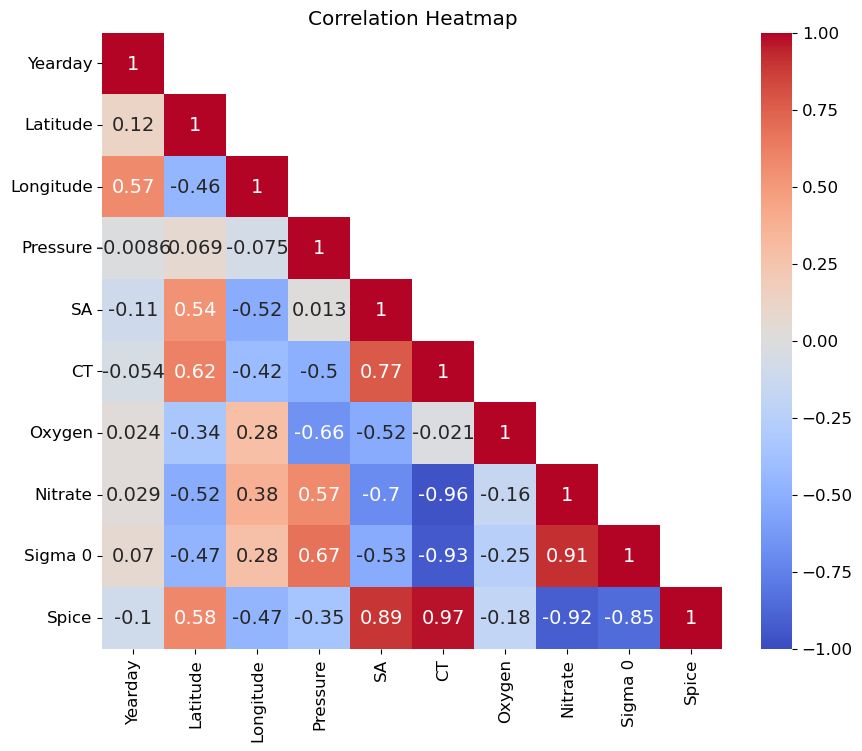

In [54]:
dfcorr = total_DF.drop({'pH', 'Julian Day', 'Sigma 1', 'Sigma 2'},axis=1).corr()
# plot a heatmap with annotation

plt.figure(figsize=(10,8))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(dfcorr, dtype=bool),k=1)
hm = sns.heatmap(dfcorr, mask=mask, annot=True, cmap='coolwarm', annot_kws={"size": 14}, center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

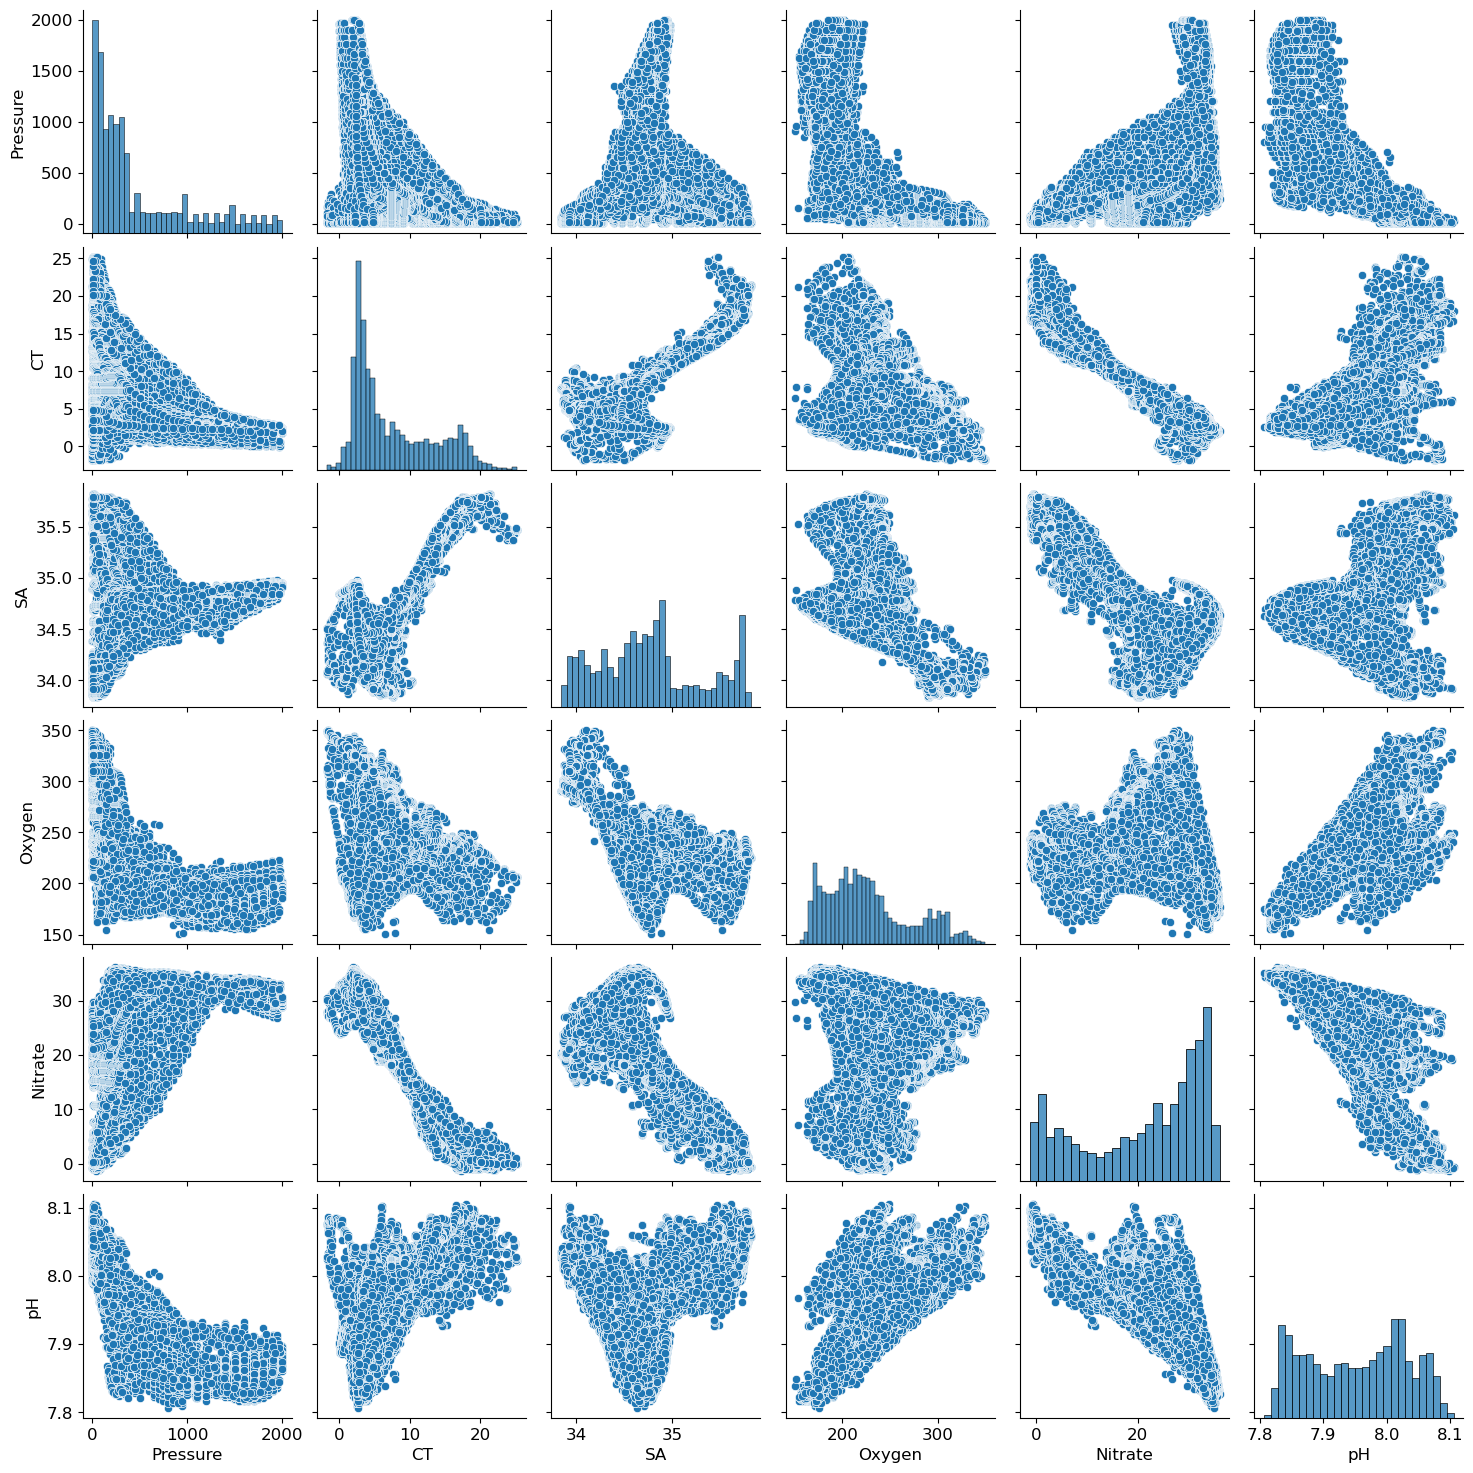

In [88]:
# Pair Wise Plots
PWDF = total_DF[["Pressure", "CT", "SA", "Oxygen", "Nitrate", 'pH']]
sns.pairplot(PWDF)
# plt.savefig("PairPlot.png")
plt.show()

### Variable distributions

n, bins, patches = plt.hist(x=TrainingDF.SA.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("Salinity")
plt.show()
n, bins, patches = plt.hist(x=TrainingDF.CT.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("Temperature")
plt.show()
n, bins, patches = plt.hist(x=TrainingDF.Oxygen.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("Oxygen")
plt.show()
n, bins, patches = plt.hist(x=TrainingDF.Nitrate.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("Nitrate")
plt.show()
n, bins, patches = plt.hist(x=TrainingDF.pH.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("pH")
plt.show()

# Random Forest Data Preparation

## Feature Scaling

In [68]:
from sklearn import preprocessing

In [69]:
total_DF

,Yearday,Julian Day,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH,Sigma 0,Sigma 1,Sigma 2,Spice
0,130.322789,2019-05-11 07:44:49.000814848,-35.0250,29.9880,7.800000,35.749064,21.245133,220.721359,-0.594459,8.070192,24.865606,29.115498,33.272639,4.281727
1,130.322789,2019-05-11 07:44:49.000814848,-35.0250,29.9880,11.800000,35.749061,21.244360,220.629868,-0.747419,8.069442,24.865816,29.115720,33.272872,4.281514
2,130.322789,2019-05-11 07:44:49.000814848,-35.0250,29.9880,15.800000,35.751057,21.236517,220.523651,-0.743400,8.069372,24.869467,29.119473,33.276725,4.280874
3,130.322789,2019-05-11 07:44:49.000814848,-35.0250,29.9880,21.799999,35.760092,21.199039,220.215622,-0.763693,8.067467,24.886532,29.137031,33.294762,4.277442
4,130.322789,2019-05-11 07:44:49.000814848,-35.0250,29.9880,25.799999,35.761097,21.181224,219.909927,-0.769277,8.066362,24.892179,29.142934,33.300915,4.273337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15793,130.749306,2019-05-11 17:58:59.999999744,-38.4994,30.0015,97.700000,35.791053,20.119472,220.700000,0.260000,8.078181,25.201648,29.468158,33.641448,4.009882
15794,130.749306,2019-05-11 17:58:59.999999744,-38.4994,30.0015,73.900000,35.791240,20.122109,220.800000,0.250000,8.079073,25.201087,29.467555,33.640805,4.010723
15795,130.749306,2019-05-11 17:58:59.999999744,-38.4994,30.0015,48.200000,35.790599,20.125722,220.800000,0.270000,8.079917,25.199645,29.466062,33.639262,4.011202
15796,130.749306,2019-05-11 17:58:59.999999744,-38.4994,30.0015,33.100000,35.790590,20.129836,221.300000,0.250000,8.081391,25.198544,29.464898,33.638037,4.012289


In [76]:
scaler = preprocessing.MinMaxScaler().fit(total_DF.drop("Julian Day",axis=1))
features = scaler.transform(total_DF.drop("Julian Day",axis=1))
feature_cols = total_DF.drop("Julian Day",axis=1).columns

scaled_DF = pd.DataFrame(features, columns=feature_cols)
scaled_DF.head()

## Splitting Train/Test/Validation Data

In [83]:
# prepare the dataset
# notice we drop nitrate because the gliders do not have this variable
# therefore, we cannot use nitrate as a predictor for when we apply the model to gliders

features = scaled_DF.drop({'pH', 'Nitrate'},axis=1)
labels = scaled_DF[["pH"]]          # array of pH values to predict

- below looks great!

In [84]:
# Using Skicit-learn to split data into training and testing sets
# from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test_val, y_train, y_test_val = train_test_split(features, labels, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 24)

# print(X_train.shape, X_test.shape, X_val.shape)
# print(y_train.shape, y_test.shape, y_val.shape)

print(str(X_train.shape[0]) + " training observations")
print(str(X_test.shape[0]) + " testing observations")
print(str(X_val.shape[0]) + " validation observations")

12638 training observations
1580 testing observations
1580 validation observations


In [85]:
training = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
validation = pd.concat([X_val, y_val], axis=1)

training.head()

,Yearday,Latitude,Longitude,Pressure,SA,CT,Oxygen,Sigma 0,Sigma 1,Sigma 2,Spice,pH
3651,0.291446,0.792433,0.060545,0.089220,0.651979,0.517518,0.427929,0.696822,0.666812,0.643075,0.414399,0.682223
5148,0.494325,0.902485,0.190015,0.068034,0.762930,0.602275,0.311952,0.628038,0.595938,0.570571,0.521194,0.688950
2133,0.089374,0.850320,0.073183,0.030951,0.942824,0.746300,0.377195,0.481450,0.450509,0.426082,0.717609,0.849600
10550,0.279906,0.643884,0.308368,0.173972,0.230601,0.216019,0.520721,0.826959,0.822985,0.819711,0.100041,0.396240
9466,0.107409,0.668855,0.208459,0.000531,0.190935,0.344167,0.680531,0.714874,0.705249,0.697547,0.167209,0.734041


In [86]:
# os.mkdir('../gridded-vars/')
file_path = '../gridded-vars/'
training.to_csv(file_path + 'SplitTraining_DF_1202.csv')
test.to_csv(file_path + 'SplitTest_DF_1202.csv')
validation.to_csv(file_path + 'SplitValidation_DF_1202.csv')

In [ ]:
# Either implement or just comment n this in discussion:
# Bootstrapping to make multiple models by sampling differently --> would give a range of estimates at each point along the glider track
# Could average over all the results (flattened pH) to get a single estimate for each point along the glider track
# Could plot the mean, and also the std along the profile

**Below trying to use torch to do splitting but fail so far**

*Comment SS:*
- personally not too familiar with torch
- will look into it!

In [ ]:
# I tried using the method in torch from tutorial 4.2 MultiLayerPerception and 4.3 CNN. They required to Zipdataset first with data and labels.

import torch
from torch.utils.data import Dataset, DataLoader

# prepare the dataset
data = TrainingDF[["Yearday","Pressure","SA","CT"]]
labels = TrainingDF[["Oxygen","Nitrate"]]
dataset = ZipDataset(data, labels, ToTensor()) # this fail, since I need to define a function for ZipDataset as custom dataframe
X,y=dataset[:]
X=X.float()
print(X.size(), torch.squeeze(X).size(), y)


L=len(dataset)
Lt = int(0.8*L)
# Lv = int(0.1*L)

# train_set, val_set, test_set = torch.utils.data.random_split(TrainingDF, [Lt, Lv, L-Lt-Lv])
train_set, val_set = torch.utils.data.random_split(dataset, [Lt,L-Lt], generator=torch.Generator().manual_seed(11))

In [ ]:
print(test_ds, valid_ds)
print(test_ds.indices, valid_ds.indices)
print(test_ds.indices.shape, valid_ds.indices.shape)

In [ ]:
BATCH_SIZE = 256
loaded_train = DataLoader(train_set, batch_size=BATCH_SIZE)
loaded_val = DataLoader(val_set, batch_size=BATCH_SIZE)
# loaded_test = DataLoader(test_set, batch_size=BATCH_SIZE)
print(loaded_train)

# X, y = next(iter(loaded_val))
# print(X.shape)

One issue -- spatiotemporal aliasing if variables are correlated?

Can you pass latitude/longitude as parameters?

# Save below code for main overview notebook

## Example to modify in sogos_overview to test different versions of model

In [ ]:
# Random Forest Model

ntrees = 1000
Mdl = RandomForestRegressor(ntrees, max_features=1/3, oob_score = True, random_state = 0)
variable = 'pH'

if variable == "pH":
    #all
    # Create X Variables for each subset of data.
    X_training = training[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", "Temperature", "Salinity", "Oxygen", "Nitrate", "N_Squared_v2"]].to_numpy()
    X_validation = validation[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", "Temperature", "Salinity", "Oxygen", "Nitrate", "N_Squared_v2"]].to_numpy()
    X_test = test[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", "Temperature", "Salinity", "Oxygen", "Nitrate", "N_Squared_v2"]].to_numpy()

    Y_training = training[variable].to_numpy()
    Y_validation = validation[variable].to_numpy()
    Y_test = test[variable].to_numpy()
    

# Fit the model to the training subset of data
Mdl.fit(X_training, Y_training)

In [ ]:
# Predict Y (pH) in each subset of data (test at the end of development)
Y_pred_training = Mdl.predict(X_training)
Y_pred_validation = Mdl.predict(X_validation)
Y_pred_test = Mdl.predict(X_test)

# Create Error Metrics 
AE_RF_training = Y_pred_training - Y_training
IQR_RF_training = iqr(abs(AE_RF_training))

AE_RF_validation = Y_pred_validation - Y_validation
IQR_RF_validation = iqr(abs(AE_RF_validation))

AE_RF_test = Y_pred_test - Y_test
IQR_RF_test = iqr(abs(AE_RF_test))

RF_dict = {}
RF_dict["Model"] = ["Training", "Validation"]
RF_dict["Median Absolute Error"] = [np.nanmedian(abs(AE_RF_training)), np.nanmedian(abs(AE_RF_validation))]
RF_dict["IQR"] = [IQR_RF_training, IQR_RF_validation]
RF_DF = pd.DataFrame.from_dict(RF_dict)
RF_DF

## Metrics/Figures for Model Evaluation

- can move this to sogos_overview as needed

In [ ]:
Mdl.feature_importances_

# plt.bar([#add list of strings for variables in the model], Mdl.feature_importances_)
# plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Out of Bag Feature Importance")
plt.savefig("RFFeatureImportancepH.png")
plt.show()
print(sum(Mdl.feature_importances_))

In [ ]:
# Example of validation metrics for nitrate
# Can change to pH

validation_RF = validation
validation_RF["Predicted Nitrate"] = Y_pred_validation
validation_RF["Error"] = Y_validation - Y_pred_validation
validation_RF["Relative Error"] = abs(validation_RF.Error.values) / Y_validation

# Split by depth and plot

validation_RF_DF = {
    "0-100": validation_RF[(validation_RF["Pressure"] >= 0) & (validation_RF["Pressure"] < 100)]["Error"].values,
    "100-200": validation_RF[(validation_RF["Pressure"] >= 100) & (validation_RF["Pressure"] < 200)]["Error"].values,
    "200-300": validation_RF[(validation_RF["Pressure"] >= 200) & (validation_RF["Pressure"] < 300)]["Error"].values,
    "300-400": validation_RF[(validation_RF["Pressure"] >= 300) & (validation_RF["Pressure"] < 400)]["Error"].values,
    "400-500": validation_RF[(validation_RF["Pressure"] >= 400) & (validation_RF["Pressure"] < 500)]["Error"].values,
    "500-600": validation_RF[(validation_RF["Pressure"] >= 500) & (validation_RF["Pressure"] < 600)]["Error"].values,
    "600-700": validation_RF[(validation_RF["Pressure"] >= 600) & (validation_RF["Pressure"] < 700)]["Error"].values,
    "700-800": validation_RF[(validation_RF["Pressure"] >= 700) & (validation_RF["Pressure"] < 800)]["Error"].values,
    "800-900": validation_RF[(validation_RF["Pressure"] >= 800) & (validation_RF["Pressure"] < 900)]["Error"].values,
    "900-1000": validation_RF[(validation_RF["Pressure"] >= 900) & (validation_RF["Pressure"] < 1000)]["Error"].values
}
dict1 = validation_RF_DF
labels, data = dict1.keys(), dict1.values()
plt.boxplot(data, vert = False, showfliers=False, widths=0.5)
plt.rcParams["figure.figsize"] = (5,5)
plt.title("Nitrate Error Distribution RF")
plt.gca().invert_yaxis()
plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths (m)")
plt.xlabel("Error (actual - predicted)")
plt.xlim(-0.025, 0.025)
# plt.savefig("BoxPlotNitraateErrorRF100.png")

plt.show()


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict